In [1]:
import numpy as np

def create_dataset(num_sequences=2**8):
    
    '''
    generates a number os sequences to be used as the data set
    
    Args:
    `num_sequences`: the number of sequences to be generated.
    
    Returns list of sequences 
    '''
    samples = []
    
    for _ in range(num_sequences): 
        num_tokens = np.random.randint(1, 12)
        sample = ['a'] * num_tokens + ['b'] * num_tokens + ['EOS']
        samples.append(sample)
        
    return samples

sequences = create_dataset()

print('A sample from the generated dataset:')
print(sequences[0]) 

A sample from the generated dataset:
['a', 'a', 'b', 'b', 'EOS']


for this project, one-hot encoding will be used to represent the vocabulary for training. For datasets with larger vocabulary however, one-hot encoding often becomes inefficient because of the size of each sparse vector. To overcome this challenge it is common practice to truncate the vocabulary to contain the most used words and represent the rest with a special symbol, UNK , to define unknown/unimportant words.

The create a one-hot encoding for the dataset, we need to assign each word in the vocabulary an index. this can be done by creating two dictionaries: One that gives the index for a given word, and one for the reverse. If a given word is not co ntained in the known vocabulary, it will be given the value of UNK. 

In [2]:
from collections import defaultdict

def sequences_to_dicts(sequences):
    
    flatten = lambda l: [item for sublist in l for item in sublist]
    
    # Flatten the dataset
    all_words = flatten(sequences)
    # Count number of word occurences
    word_count = defaultdict(int)
    for word in flatten(sequences):
        word_count[word] += 1

    # Sort by frequency
    word_count = sorted(list(word_count.items()), key=lambda l: -l[1])
    # Create a list of all unique words
    unique_words = [item[0] for item in word_count]
    # Add UNK token to list of words
    unique_words.append('UNK')
    # Count number of sequences and number of unique words
    num_sentences, vocab_size = len(sequences), len(unique_words)
    # Create dictionaries to go from word to index and back
    # If a word is not in the vocabulary, it will be assigned to token 'UNK'
    word_to_idx = defaultdict(lambda: vocab_size-1)
    idx_to_word = defaultdict(lambda: 'UNK')
    # Fill dictionaries
    for idx, word in enumerate(unique_words):
        word_to_idx[word] = idx
        idx_to_word[idx] = word

    return word_to_idx, idx_to_word, num_sentences, vocab_size


word_to_idx, idx_to_word, num_sequences, vocab_size = sequences_to_dicts(sequences)

print(f'{num_sequences} sentences and {len(word_to_idx)} unique tokens in dataset (including UNK).\n')
print('The index of \'b\' is', word_to_idx['b'])
print(f'The word corresponding to index 1 is \'{idx_to_word[1]}\'')

assert idx_to_word[word_to_idx['b']] == 'b', \
    'Consistency error: something went wrong in the conversion.'

256 sentences and 4 unique tokens in dataset (including UNK).

The index of 'b' is 1
The word corresponding to index 1 is 'b'


In [3]:
from torch.utils import data


class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y

/opt/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def create_datasets(sequences, dataset_class, p_train=0.8, p_val=0.1, p_test=0.1):
    # Define partition sizes
    num_train = int(len(sequences)*p_train)
    num_val = int(len(sequences)*p_val)
    num_test = int(len(sequences)*p_test)

    # Split sequences into partitions
    sequences_train = sequences[:num_train]
    sequences_val = sequences[num_train:num_train+num_val]
    sequences_test = sequences[-num_test:]

    def get_inputs_targets_from_sequences(sequences):
        # Define empty lists
        inputs, targets = [], []
        
        # Append inputs and targets s.t. both lists contain L-1 words of a sentence of length L
        # but targets are shifted right by one so that we can predict the next word
        for sequence in sequences:
            inputs.append(sequence[:-1])
            targets.append(sequence[1:])
            
        return inputs, targets

    # Get inputs and targets for each partition
    inputs_train, targets_train = get_inputs_targets_from_sequences(sequences_train)
    inputs_val, targets_val = get_inputs_targets_from_sequences(sequences_val)
    inputs_test, targets_test = get_inputs_targets_from_sequences(sequences_test)

    # Create datasets
    training_set = dataset_class(inputs_train, targets_train)
    validation_set = dataset_class(inputs_val, targets_val)
    test_set = dataset_class(inputs_test, targets_test)

    return training_set, validation_set, test_set

In [5]:
training_set, validation_set, test_set = create_datasets(sequences, Dataset)

print(f'{len(training_set)} samples in the training set.')
print(f'{len(validation_set)} samples in the validation set.')
print(f'{len(test_set)} samples in the test set.')

204 samples in the training set.
25 samples in the validation set.
25 samples in the test set.


In [6]:
def one_hot_encode(idx, vocab_size):
    """
    One-hot encodes a single word given its index and the size of the vocabulary.
    
    Args:
     `idx`: the index of the given word
     `vocab_size`: the size of the vocabulary
    
    Returns a 1-D numpy array of length `vocab_size`.
    """
    # Initialize the encoded array
    one_hot = np.zeros(vocab_size)
    # Set the appropriate element to one
    one_hot[idx] = 1.0

    return one_hot


def one_hot_encode_sequence(sequence, vocab_size):
    """
    One-hot encodes a sequence of words given a fixed vocabulary size.
    
    Args:
     `sequence`: a list of words to encode
     `vocab_size`: the size of the vocabulary
     
    Returns a 3-D numpy array of shape (num words, vocab size, 1).
    """
    # Encode each word in the sentence
    encoding = np.array([one_hot_encode(word_to_idx[word], vocab_size) for word in sequence])

    # Reshape encoding s.t. it has shape (num words, vocab size, 1)
    encoding = encoding.reshape(encoding.shape[0], encoding.shape[1], 1)
    
    return encoding


In [7]:
test_word = one_hot_encode(word_to_idx['a'], vocab_size)
print(f'one-hot encoding of \'a\' has shape {test_word.shape}.')

test_sentence = one_hot_encode_sequence(['a', 'b'], vocab_size)
print(f'one-hot encoding of \'a b\' has shape {test_sentence.shape}.')


one-hot encoding of 'a' has shape (4,).
one-hot encoding of 'a b' has shape (2, 4, 1).


In [8]:
hidden_size = 50 # Number of dimensions in the hidden state
vocab_size  = len(word_to_idx) # Size of the vocabulary used
z_size = hidden_size + vocab_size # Size of concatenated hidden + input vector

def init_orthogonal(param):
    # Initializes weight parameters orthogonally
    if param.ndim < 2:
        raise ValueError("Only parameters with 2 or more dimensions are supported.")
    
    rows, cols = param.shape
    new_param = np.random.randn(rows, cols)
    if rows < cols:
        new_param = new_param.T    
    
    # Compute QR factorization
    q, r = np.linalg.qr(new_param)
    
    # Make Q uniform 
    d = np.diag(r, 0)
    ph = np.sign(d)
    q *= ph

    if rows < cols:
        q = q.T
    
    new_param = q
    return new_param


def init_lstm(hidden_size, vocab_size, z_size):
    """
    Initializes LSTM network.
    
    Args:
     `hidden_size`: the dimensions of the hidden state
     `vocab_size`: the dimensions of vocabulary
     `z_size`: the dimensions of the concatenated input 
    """
    # Weight matrix (forget gate)
    W_f = np.zeros((hidden_size, z_size))
    
    # Bias for forget gate
    b_f = np.zeros((hidden_size, 1))

    # Weight matrix (input gate)
    W_i = np.zeros((hidden_size, z_size))
    
    # Bias for input gate
    b_i = np.zeros((hidden_size, 1))

    # Weight matrix (candidate)
    W_g = np.zeros((hidden_size, z_size))
    
    # Bias for candidate
    b_g = np.zeros((hidden_size, 1))

    # Weight matrix of the output gate
    W_o = np.zeros((hidden_size, z_size))
    
    # Bias for output gate
    b_o = np.zeros((hidden_size, 1))

    # Weight matrix relating the hidden-state to the output
    W_v = np.zeros((vocab_size, hidden_size))
    
    # Bias for logits
    b_v = np.zeros((vocab_size, 1))
    
    # Initialize weights according to https://arxiv.org/abs/1312.6120
    W_f = init_orthogonal(W_f)
    W_i = init_orthogonal(W_i)
    W_g = init_orthogonal(W_g)
    W_o = init_orthogonal(W_o)
    W_v = init_orthogonal(W_v)

    return W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v


params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)
print('W_f:', params[0].shape)
print('W_i:', params[1].shape)
print('W_g:', params[2].shape)
print('W_o:', params[3].shape)
print('W_v:', params[4].shape)
print('b_i:', params[5].shape)
print('b_g:', params[6].shape)
print('b_o:', params[7].shape)
print('b_v:', params[8].shape)

for param in params:
    assert param.ndim == 2, \
        'all parameters should be 2-dimensional '\
        '(hint: a dimension can simply have size 1)'

W_f: (50, 54)
W_i: (50, 54)
W_g: (50, 54)
W_o: (50, 54)
W_v: (4, 50)
b_i: (50, 1)
b_g: (50, 1)
b_o: (50, 1)
b_v: (50, 1)


In [9]:
def sigmoid(x, derivative=False):
    """
    Computes the element-wise sigmoid activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = 1 / (1 + np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return f * (1 - f)
    else: # Return the forward pass of the function at x
        return f

In [10]:
def tanh(x, derivative=False):
    """
    Computes the element-wise tanh activation function for an array x.

    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12 
    f = (np.exp(x_safe)-np.exp(-x_safe))/(np.exp(x_safe)+np.exp(-x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        return 1-f**2
    else: # Return the forward pass of the function at x
        return f

In [11]:
def softmax(x, derivative=False):
    """
    Computes the softmax for an array x.
    
    Args:
     `x`: the array where the function is applied
     `derivative`: if set to True will return the derivative instead of the forward pass
    """
    x_safe = x + 1e-12
    f = np.exp(x_safe) / np.sum(np.exp(x_safe))
    
    if derivative: # Return the derivative of the function evaluated at x
        pass
    else: # Return the forward pass of the function at x
        return f

In [12]:
def forward(inputs, h_prev, C_prev, p):
    """
    Arguments:
    x -- input data at timestep "t", numpy array of shape (n_x, m).
    h_prev -- Hidden state at timestep "t-1", numpy array of shape (n_a, m)
    C_prev -- Memory state at timestep "t-1", numpy array of shape (n_a, m)
    p -- python list containing:
                        W_f -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        b_f -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        W_i -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        b_i -- Bias of the update gate, numpy array of shape (n_a, 1)
                        W_g -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        b_g --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        W_o -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        b_o --  Bias of the output gate, numpy array of shape (n_a, 1)
                        W_v -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_v, n_a)
                        b_v -- Bias relating the hidden-state to the output, numpy array of shape (n_v, 1)
    Returns:
    z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s -- lists of size m containing the computations in each forward pass
    outputs -- prediction at timestep "t", numpy array of shape (n_v, m)
    """
    assert h_prev.shape == (hidden_size, 1)
    assert C_prev.shape == (hidden_size, 1)

    # unpacking parameters
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p
    
    # Save a list of computations for each of the components in the LSTM
    x_s, z_s, f_s, i_s,  = [], [] ,[], []
    g_s, C_s, o_s, h_s = [], [] ,[], []
    v_s, output_s =  [], [] 
    
    # Append the initial cell and hidden state to their respective lists
    h_s.append(h_prev)
    C_s.append(C_prev)
    
    for x in inputs:
        
        # Concatenate input and hidden state
        z = np.row_stack((h_prev, x))
        z_s.append(z)
        
        # Calculate forget gate
        # YOUR CODE HERE!
        f = sigmoid(np.dot(W_f, z)) + b_f
        f_s.append(f)
        
        # Calculate input gate
        i = sigmoid(np.dot(W_i, z)) + b_i
        i_s.append(i)
        
        # Calculate candidate
        g = tanh(np.dot(W_g, z) + b_g)
        g_s.append(g)
        
        # Calculate memory state
        C_prev = f * C_prev + i * g
        C_s.append(C_prev)
        
        # Calculate output gate
        o =  sigmoid(np.dot(W_o, z)) + b_o
        o_s.append(o)
        
        # Calculate hidden state
        h_prev = o * tanh(C_prev)
        h_s.append(h_prev)

        # Calculate logits
        v = np.dot(W_v, h_prev) + b_v
        v_s.append(v)
        
        # Calculate softmax
        output = softmax(v)
        output_s.append(output)

    return z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, output_s


# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Initialize hidden state as zeros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Forward pass
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

Input sentence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Predicted sequence:
['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'EOS', 'EOS', 'b', 'b', 'b', 'b', 'b', 'b', 'b']


In [13]:
def clip_gradient_norm(grads, max_norm=0.25):
    """
    Clips gradients to have a maximum norm of `max_norm`.
    This is to prevent the exploding gradients problem.
    """ 
    # Set the maximum of the norm to be of type float
    max_norm = float(max_norm)
    total_norm = 0
    
    # Calculate the L2 norm squared for each gradient and add them to the total norm
    for grad in grads:
        grad_norm = np.sum(np.power(grad, 2))
        total_norm += grad_norm
    
    total_norm = np.sqrt(total_norm)
    
    # Calculate clipping coeficient
    clip_coef = max_norm / (total_norm + 1e-6)
    
    # If the total norm is larger than the maximum allowable norm, then clip the gradient
    if clip_coef < 1:
        for grad in grads:
            grad *= clip_coef
    
    return grads

def backward(z, f, i, g, C, o, h, v, outputs, targets, p = params):
    """
    Arguments:
    z -- your concatenated input data  as a list of size m.
    f -- your forget gate computations as a list of size m.
    i -- your input gate computations as a list of size m.
    g -- your candidate computations as a list of size m.
    C -- your Cell states as a list of size m+1.
    o -- your output gate computations as a list of size m.
    h -- your Hidden state computations as a list of size m+1.
    v -- your logit computations as a list of size m.
    outputs -- your outputs as a list of size m.
    targets -- your targets as a list of size m.
    p -- python list containing:
                        W_f -- Weight matrix of the forget gate, numpy array of shape (n_a, n_a + n_x)
                        b_f -- Bias of the forget gate, numpy array of shape (n_a, 1)
                        W_i -- Weight matrix of the update gate, numpy array of shape (n_a, n_a + n_x)
                        b_i -- Bias of the update gate, numpy array of shape (n_a, 1)
                        W_g -- Weight matrix of the first "tanh", numpy array of shape (n_a, n_a + n_x)
                        b_g --  Bias of the first "tanh", numpy array of shape (n_a, 1)
                        W_o -- Weight matrix of the output gate, numpy array of shape (n_a, n_a + n_x)
                        b_o --  Bias of the output gate, numpy array of shape (n_a, 1)
                        W_v -- Weight matrix relating the hidden-state to the output, numpy array of shape (n_v, n_a)
                        b_v -- Bias relating the hidden-state to the output, numpy array of shape (n_v, 1)
    Returns:
    loss -- crossentropy loss for all elements in output
    grads -- lists of gradients of every element in p
    """

    # Unpack parameters
    W_f, W_i, W_g, W_o, W_v, b_f, b_i, b_g, b_o, b_v = p

    # Initialize gradients as zero
    W_f_d = np.zeros_like(W_f)
    b_f_d = np.zeros_like(b_f)

    W_i_d = np.zeros_like(W_i)
    b_i_d = np.zeros_like(b_i)

    W_g_d = np.zeros_like(W_g)
    b_g_d = np.zeros_like(b_g)

    W_o_d = np.zeros_like(W_o)
    b_o_d = np.zeros_like(b_o)

    W_v_d = np.zeros_like(W_v)
    b_v_d = np.zeros_like(b_v)
    
    # Set the next cell and hidden state equal to zero
    dh_next = np.zeros_like(h[0])
    dC_next = np.zeros_like(C[0])
        
    # Track loss
    loss = 0
    
    for t in reversed(range(len(outputs))):
        
        # Compute the cross entropy
        loss += -np.mean(np.log(outputs[t]) * targets[t])
        # Get the previous hidden cell state
        C_prev= C[t-1]
        
        # Compute the derivative of the relation of the hidden-state to the output gate
        dv = np.copy(outputs[t])
        dv[np.argmax(targets[t])] -= 1

        # Update the gradient of the relation of the hidden-state to the output gate
        W_v_d += np.dot(dv, h[t].T)
        b_v_d += dv

        # Compute the derivative of the hidden state and output gate
        dh = np.dot(W_v.T, dv)        
        dh += dh_next
        do = dh * tanh(C[t])
        do = sigmoid(o[t], derivative=True)*do
        
        # Update the gradients with respect to the output gate
        W_o_d += np.dot(do, z[t].T)
        b_o_d += do

        # Compute the derivative of the cell state and candidate g
        dC = np.copy(dC_next)
        dC += dh * o[t] * tanh(tanh(C[t]), derivative=True)
        dg = dC * i[t]
        dg = tanh(g[t], derivative=True) * dg
        
        # Update the gradients with respect to the candidate
        W_g_d += np.dot(dg, z[t].T)
        b_g_d += dg

        # Compute the derivative of the input gate and update its gradients
        di = dC * g[t]
        di = sigmoid(i[t], True) * di
        W_i_d += np.dot(di, z[t].T)
        b_i_d += di

        # Compute the derivative of the forget gate and update its gradients
        df = dC * C_prev
        df = sigmoid(f[t]) * df
        W_f_d += np.dot(df, z[t].T)
        b_f_d += df

        # Compute the derivative of the input and update the gradients of the previous hidden and cell state
        dz = (np.dot(W_f.T, df)
             + np.dot(W_i.T, di)
             + np.dot(W_g.T, dg)
             + np.dot(W_o.T, do))
        dh_prev = dz[:hidden_size, :]
        dC_prev = f[t] * dC
        
    grads= W_f_d, W_i_d, W_g_d, W_o_d, W_v_d, b_f_d, b_i_d, b_g_d, b_o_d, b_v_d
    
    # Clip gradients
    grads = clip_gradient_norm(grads)
    
    return loss, grads


# Perform a backward pass
loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)

print('We get a loss of:')
print(loss)

We get a loss of:
4.7019778386592606


In [14]:
def update_parameters(params, grads, lr=1e-3):
    # Take a step
    for param, grad in zip(params, grads):
        param -= lr * grad 
    
    return params

Epoch 0, training loss: 4.156733540367533, validation loss: 4.08704647829934
Epoch 50, training loss: 2.3383270598421393, validation loss: 2.308388965842491
Epoch 100, training loss: 1.6697724251345192, validation loss: 1.6585636814266909
Epoch 150, training loss: 1.4120583028083307, validation loss: 1.4008590615585084
Epoch 200, training loss: 1.3140430586356788, validation loss: 1.3002962801669784
Epoch 250, training loss: 1.273157986351839, validation loss: 1.253658767160099
Input sentence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']

Target sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']

Predicted sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b']


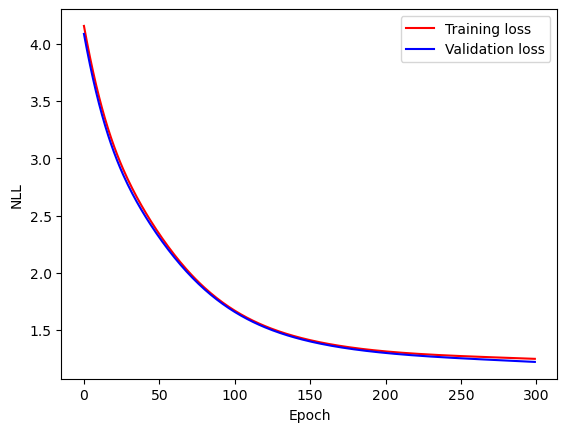

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# Hyper-parameters
num_epochs = 300

# Initialize a new network
z_size = hidden_size + vocab_size # Size of concatenated hidden + input vector
params = init_lstm(hidden_size=hidden_size, vocab_size=vocab_size, z_size=z_size)

# Initialize hidden state as zeros
hidden_state = np.zeros((hidden_size, 1))

# Track loss
training_loss, validation_loss = [], []

# For each epoch
for i in range(num_epochs):
    
    # Track loss
    epoch_training_loss = 0
    epoch_validation_loss = 0
    
    # For each sentence in validation set
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Initialize hidden state and cell state as zeros
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward pass
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        
        # Backward pass
        loss, _ = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)
        
        # Update loss
        epoch_validation_loss += loss
    
    # For each sentence in training set
    for inputs, targets in training_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Initialize hidden state and cell state as zeros
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward pass
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        
        # Backward pass
        loss, grads = backward(z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs, targets_one_hot, params)
        # Update parameters
        params = update_parameters(params, grads, lr=1e-3)
        
        # Update loss
        epoch_training_loss += loss
                
    # Save loss for plot
    training_loss.append(epoch_training_loss/len(training_set))
    validation_loss.append(epoch_validation_loss/len(validation_set))

    # Print loss every 10 epochs
    if i % 50 == 0:
        print(f'Epoch {i}, training loss: {training_loss[-1]}, validation loss: {validation_loss[-1]}')

    
# Get first sentence in test set
inputs, targets = test_set[1]

# One-hot encode input and target sequence
inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

# Initialize hidden state as zeros
h = np.zeros((hidden_size, 1))
c = np.zeros((hidden_size, 1))

# Forward pass
z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)

# Print example
print('Input sentence:')
print(inputs)

print('\nTarget sequence:')
print(targets)

print('\nPredicted sequence:')
print([idx_to_word[np.argmax(output)] for output in outputs])

# Plot training and validation loss
epoch = np.arange(len(training_loss))
plt.figure()
plt.plot(epoch, training_loss, 'r', label='Training loss',)
plt.plot(epoch, validation_loss, 'b', label='Validation loss')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()


In [16]:
    for inputs, targets in validation_set:
        
        # One-hot encode input and target sequence
        inputs_one_hot = one_hot_encode_sequence(inputs, vocab_size)
        targets_one_hot = one_hot_encode_sequence(targets, vocab_size)

        # Initialize hidden state and cell state as zeros
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))

        # Forward pass
        z_s, f_s, i_s, g_s, C_s, o_s, h_s, v_s, outputs = forward(inputs_one_hot, h, c, params)
        output_sentence = [idx_to_word[np.argmax(output)] for output in outputs]
        print('Input sentence:')
        print(inputs)
        print('Target sequence:')
        print(targets)
        print('Predicted sequence:')
        print([idx_to_word[np.argmax(output)] for output in outputs])

Input sentence:
['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']
Target sequence:
['a', 'a', 'a', 'b', 'b', 'b', 'b', 'EOS']
Predicted sequence:
['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b']
Input sentence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b']
Target sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Predicted sequence:
['a', 'a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'EOS']
Input sentence:
['a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b']
Target sequence:
['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', 'EOS']
Predicted sequence:
['a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b']
Input sentence:
['a', 'a', 'a', 'b', 'b', 'b']
Target sequence:
['a', 'a', 'b', 'b', 'b', 'EOS']
Predicted sequence:
['a', 'a', 'a', 'b', 'b', 'b']
Input sentence:
['a', 'a', 'b', 'b']
Target sequence:
['a', 'b', 'b', 'EOS']
Predicted sequence:
['a', 'a', 'b', 'b']
Input sentence:
['a', 'a', 'a', 'a', 'a', 'a', '